In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow import keras
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import csv
import pickle
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from datetime import datetime
import numpy as np # type: ignore
print("Numpy version:", np.__version__)
from sklearn.preprocessing import Normalizer
# from get_dataset import datasets
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

sys.path.append("..")
sys.path.append("../analyze")
sys.path.append("../measuring_volume")
sys.path.append("../common")
import pickle
from classify_seq import make_input_seq as mis

import keras_tuner as kt

type_of_l = "L1"

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


TensorFlow version: 2.16.1
Numpy version: 1.26.4


## Loading a dataset

## Split into train data and test data as dataset

データセットからx, yを作成する

In [10]:
# [0, 1, ... 0] + temperature + eigenvalue
f1 = open("../dataset/x_initial_L1.pkl", "rb")
f2 = open("../dataset/L1_data_initial.pkl", "rb")
# f_x2=["../dataset/x_QD_1_L1.pkl"]
# f_y2=["../dataset/L1_data_QD_1.pkl"]
domain_seq_dic = pickle.load(f1)
value_dic = pickle.load(f2)
# for fx in f_x2:
#     fx = open(fx, "rb")
#     domain_seq_dic.update(pickle.load(fx))
# for fy in f_y2:
#     fy = open(fy, "rb")
#     value_dic.update(pickle.load(fy))
domain_lst = mis.seq_lst(f"../conf/input_seq_{type_of_l}.csv")

f1.close()
f2.close()

x_data = []
y_data = []

for key in domain_seq_dic:
    new_x = []
    for domain in domain_lst:
        new_x.append(domain_seq_dic[key]["domain"][domain])
    new_x.append(int(key[0]))
    new_x.append(float(domain_seq_dic[key]['eigenValue_2']))
    x_data.append(new_x)
    y_data.append(value_dic[(key[0], key[1][1:])]['mean_volume'])

print(x_data)
print(y_data)



[[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 277, 0.9408559060769692], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 298, 0.9319160688429027], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 308, 0.9260851792260768], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 318, 0.919023732182346], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 328, 0.9108854470927561], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 338, 0.9038784107602371], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 348, 0.9080578848046009], [1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 358, 0.9339797477050081], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 277, 0.9217893080361136], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 298, 0.9063306507027413], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 308, 0.8962594790795997], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 318, 0.8837909480624144], [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 328, 0.8682604764972498], [1, 1, 0, 0, 1, 1, 1, 0, 

In [11]:
x_data = np.array(x_data)
y_data = np.array(y_data)

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=1)

print(len(x_train))


128


## Set my model
- input_shape は入力データのサイズ。
- モデルの定義方法は調べればたくさん出てきますが、例えばここ： https://sinyblog.com/deaplearning/keras_how_to/ 
- 最後の層の出力は、期待する出力データのサイズ
- [model](https://github.com/si-tm/docs-l10n/blob/master/site/ja/tutorials/quickstart/beginner.py)

In [12]:
def build_model():
    
    # model = tf.keras.models.Sequential([
    # tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    # tf.keras.layers.Dense(128, activation='relu'), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    # tf.keras.layers.Dense(1) 
    # ])

    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(x_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu', name="layer1"), # units=128 : 出力空間の次元数
    tf.keras.layers.Dense(128, activation='relu', name="layer2"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer3"), # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer4"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    # tf.keras.layers.Dense(128, activation='relu', name="layer5"), # units=128 : 出力空間の次元数 # units=128 : 出力空間の次元数
    tf.keras.layers.Dropout(0.2), # 入力にドロップアウトを適用する rate=0.2 : 入力ユニットをドロップする割合
    tf.keras.layers.Dense(1) 
    ])

    optimizer = tf.keras.optimizers.Adam() # optimizers も Adam 以外に色々種類があります。調べてみてください！

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse']) # loss 関数に何を採用するかはどんな問題を解きたいのかによります。
                                        #ここでは MSE を採用していますが、他にも色々な選択肢があります。調べてみてください！
    return model

In [13]:
model = build_model()

/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1 (Dense)                  │ (None, 128)            │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer2 (Dense)                  │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,073 (74.50 KB)

 Trainable params: 19,073 (74.50 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
example_batch = x_train[:10]
print(example_batch.shape)
example_result = model.predict(example_batch)
# example_result

(10, 18)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [16]:
print(example_result)

[[45.247276]
 [40.20252 ]
 [38.842922]
 [44.04343 ]
 [45.398907]
 [42.662018]
 [37.828094]
 [34.91339 ]
 [41.471832]
 [43.98065 ]]


In [17]:
# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 100 # epoch 数も考慮しよう
# EPOCHS = 100 # epoch 数も考慮しよう

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,2.500523,1.358596,2.500523,2.057714,1.354376,2.057714,95
96,2.304262,1.252045,2.304262,1.977243,1.269398,1.977243,96
97,2.805150,1.396368,2.805150,2.403739,1.466886,2.403739,97
98,2.665872,1.386722,2.665872,2.276715,1.434816,2.276715,98
99,2.610219,1.383496,2.610219,2.073167,1.219280,2.073167,99


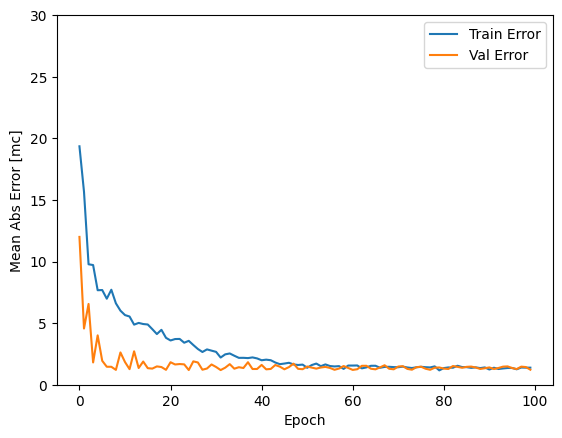

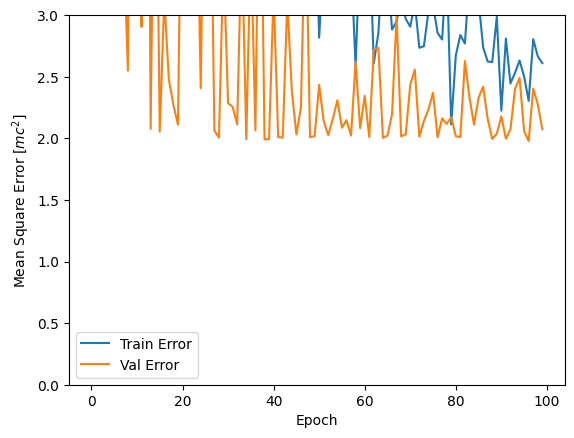

In [19]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [mc]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label = 'Val Error')
    plt.ylim([0,30])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$mc^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.ylim([0,3])
    plt.legend()
    plt.show()


plot_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


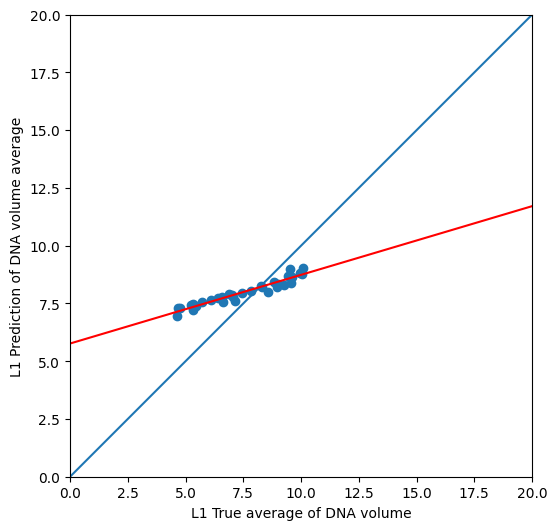

In [20]:
test_predictions = model.predict(x_test).flatten()
res = linregress(y_test, test_predictions)

plt.figure(figsize=(6,6))
plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values [mc]')
# plt.ylabel('Predictions [mc]')
plt.xlabel('L1 True average of DNA volume')
plt.ylabel('L1 Prediction of DNA volume average')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,20])
plt.ylim([0,20])
_ = plt.plot([0,20], [0,20])

plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

# normalizer 学習前

In [31]:
model.save('../saved_model/L1_initial_eigen.keras')

In [22]:
from keras.models import load_model

def getModel(path="../saved_model/l1_ave_230710"):
    model = load_model(path)
    return model


In [23]:

mse = tf.keras.losses.MeanSquaredError()

In [34]:
from sklearn.datasets import load_diabetes, make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from tensorflow import keras 
import tensorflow as tf
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages

In [35]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
def randomforest_regressor(x, y, x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2, random_state=0)
    regr.fit(x_train, y_train)
    return regr.score(x_test, y_test)


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html#sklearn.ensemble.ExtraTreesRegressor
def extratrees_regressor(x, y, x_train, x_test, y_train, y_test):
    # X_train, X_test, y_train, y_test = train_test_split(
    #     X, y, random_state=0)
    reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(
    x_train, y_train)
    return reg.score(x_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def gradientboosting_regressor(X_train, X_test, y_train, y_test):
    reg = GradientBoostingRegressor(random_state=0)
    reg.fit(X_train, y_train)
    return reg.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor
def stacking_regressor(X_train, X_test, y_train, y_test):
    X, y = load_diabetes(return_X_y=True)
    estimators = [
        ('lr', RidgeCV()),
        ('svr', LinearSVR(random_state=42))
    ]
    reg = StackingRegressor(
        estimators=estimators,
        final_estimator=RandomForestRegressor(n_estimators=10,
                                            random_state=42)
    )
    ref = reg.fit(X_train, y_train)
    return ref.score(X_test, y_test)

# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html#sklearn.ensemble.VotingRegressor
def voting_regressor(X, y, x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10, random_state=1)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    print(type(x_test))
    er.predict(x_test)
    return er.score(x_test, y_test)

# def voting_regressor(x_train, x_test, y_train, y_test):
#     # 各モデルのインスタンスを作成
#     r1 = LinearRegression()
#     r2 = RandomForestRegressor(n_estimators=10, random_state=1)
#     r3 = KNeighborsRegressor()
    
#     # VotingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
#     er = VotingRegressor([('lr', r1), ('rf', r2), ('knn', r3)])
#     er.fit(x_train, y_train)
    
#     # テストデータに対して予測を行う
#     # predictions = er.predict(x_test)
    
#     # モデルのスコアを計算して返す
#     score = er.score(x_test, y_test)
    
#     return score


# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
def histgradientboosting_regressor(X, y, x_train, x_test, y_train, y_test):
    # est = HistGradientBoostingRegressor().fit(X, y)
    est = HistGradientBoostingRegressor().fit(x_train, y_train)
    return est.score(x_test, y_test)

def get_model():
    # Create a simple model.
    inputs = keras.Input(shape=(32,))
    outputs = keras.layers.Dense(1)(inputs)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

def neural_mse(x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_l1_6_model'):
    #y_data = np.concatenate([np.array(y_train),np.array(y_test)])
    #print(type(y_data), y_data.shape)
    #min_val = y_data.min()
    #max_val = y_data.max()
    #y_train = (y_train - min_val)/(max_val - min_val)
    #y_test = (y_test - min_val)/(max_val - min_val)
    #x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()
    for i in range(len(y_test)):
        print(f"Expected {y_test[i]} and got {test_predictions[i]}")

    #mse = tf.keras.losses.MeanSquaredError()
    u = ((y_test-test_predictions)**2).sum()
    v = ((y_test - y_test.mean()) ** 2).sum()

    return 1.0 - u/v #mse(y_test,test_predictions).numpy()

def new_neural_mse(x, y, x_train, x_test, y_train, y_test, model_path='../../script/saved_model/random_l1_6_model'):

    model = keras.models.load_model(model_path)
    test_predictions = model.predict(x_test).flatten()

    mse = tf.keras.losses.MeanSquaredError()

    return mse(y_test,test_predictions).numpy()


In [37]:
x = x_data
y = y_data

print(np.isnan(x_test).sum())  # 欠損値の数を確認
print(x_test.shape)  # 形状を確認

extratrees = extratrees_regressor(x, y, x_train, x_test, y_train, y_test)
randomforest = randomforest_regressor(x, y, x_train, x_test, y_train, y_test) 
gradientboosting = gradientboosting_regressor(x_train, x_test, y_train, y_test)
stacking = stacking_regressor(x_train, x_test, y_train, y_test)
# voting = voting_regressor(x, y, x_train, x_test, y_train, y_test)
histgradientboosting = histgradientboosting_regressor(x, y, x_train, x_test, y_train, y_test)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L1_initial_eigen.keras')


0
(32, 18)


/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/hyakuzukamaya/Library/P

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Expected 9.02095429019781 and got 8.326700210571289
Expected 6.565601871516233 and got 7.760177135467529
Expected 9.58432819503382 and got 8.396699905395508
Expected 6.865394633357768 and got 7.920827865600586
Expected 5.234178224151062 and got 7.426399230957031
Expected 9.244999652286877 and got 8.319656372070312
Expected 8.27813967918836 and got 8.274885177612305
Expected 7.140468009029306 and got 7.620086193084717
Expected 4.636756343331214 and got 6.961337566375732
Expected 5.337439879974527 and got 7.2366156578063965
Expected 5.465523750034848 and got 7.40535831451416
Expected 9.442568340531626 and got 8.692726135253906
Expected 4.6559529492363785 and got 7.285341262817383
Expected 4.772257053817116 and got 7.284233093261719
Expected 7.463049477450096 and got 7.972530841827393
Expected 6.1153800657924595 and got 7.663087844848633
Expected 6.413698402810804 and got 7.7482428550720215
Expected 9.59190278073022 and got 8.638006210327148
Expected 

In [38]:
def bagging_regressor(estimator, x_train, x_test, y_train, y_test):
    # BaggingRegressorのインスタンスを作成し、トレーニングデータにフィットさせる
    er = BaggingRegressor(estimator=estimator, n_estimators=10, random_state=1)
    er.fit(x_train, y_train)
    
    # モデルのスコアを計算して返す
    score = er.score(x_test, y_test)
    
    return score

In [40]:
x = x_data
y = y_data


# 各種モデルのバギングを実行
extratrees = bagging_regressor(ExtraTreesRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("ExtraTreesRegressor with Bagging Score:", extratrees)

randomforest = bagging_regressor(RandomForestRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("RandomForestRegressor with Bagging Score:", randomforest)

gradientboosting = bagging_regressor(GradientBoostingRegressor(n_estimators=10, random_state=1), x_train, x_test, y_train, y_test)
print("GradientBoostingRegressor with Bagging Score:", gradientboosting)

# スタッキングの例
estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=1)),
    ('et', ExtraTreesRegressor(n_estimators=10, random_state=1))
]
stacking_estimator = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
stacking = bagging_regressor(stacking_estimator, x_train, x_test, y_train, y_test)
print("StackingRegressor with Bagging Score:", stacking)

histgradientboosting = bagging_regressor(HistGradientBoostingRegressor(random_state=1), x_train, x_test, y_train, y_test)
print("HistGradientBoostingRegressor with Bagging Score:", histgradientboosting)
neural_mse_score = neural_mse(x_train, x_test, y_train, y_test, model_path='../saved_model/L1_initial_eigen.keras')


ExtraTreesRegressor with Bagging Score: 0.9735455848051954
RandomForestRegressor with Bagging Score: 0.9734776369766206
GradientBoostingRegressor with Bagging Score: 0.8501539935283817
StackingRegressor with Bagging Score: 0.972227455553549
HistGradientBoostingRegressor with Bagging Score: 0.9507153746647428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Expected 9.02095429019781 and got 8.326700210571289
Expected 6.565601871516233 and got 7.760177135467529
Expected 9.58432819503382 and got 8.396699905395508
Expected 6.865394633357768 and got 7.920827865600586
Expected 5.234178224151062 and got 7.426399230957031
Expected 9.244999652286877 and got 8.319656372070312
Expected 8.27813967918836 and got 8.274885177612305
Expected 7.140468009029306 and got 7.620086193084717
Expected 4.636756343331214 and got 6.961337566375732
Expected 5.337439879974527 and got 7.2366156578063965
Expected 5.465523750034848 and got 7.40535831451416
Expected 9.442568340531626 and got 8.692726135253906
Expected 4.65595294

In [41]:
## これ！！

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

        # Save the model
    with open('../saved_model/bagging_model_L1_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    max_lim = 45

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,max_lim])
    plt.ylim([0,max_lim])
    _ = plt.plot([0,max_lim], [0,max_lim])

    print(er.score(x_test, y_test))

    

    plt.plot([0,max_lim], res.intercept + res.slope*np.array([0, max_lim]), 'r', label='fitted line')

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# データ
lst = [
    ["extratrees", extratrees],
    ["randomforest", randomforest],
    ["gradientboosting", gradientboosting],
    ["stacking", stacking],
    # ["voting", voting],  # コメントアウト中
    ["histgradientboosting", histgradientboosting],
    ["neural network", neural_mse_score]
]

# データフレームの作成
df = pd.DataFrame(data=lst, columns=['regressor', 'score'])
print(df)

# PDFへの保存
pdf_path = 'regressor_scores_L1.pdf'

# プロットをPDFに保存するための設定
with PdfPages(pdf_path) as pdf:
    # データフレームをプロット
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # テーブルのスタイル設定
    table.auto_set_font_size(False)
    table.set_fontsize(7)
    table.scale(1.5, 1.5)

    # セルのスタイル設定
    for (i, j), cell in table.get_celld().items():
        cell.set_edgecolor('grey')
        if i == 0:  # Header row
            cell.set_text_props(weight='bold', color='white')
            cell.set_facecolor('#40466e')
        else:  # Data cells
            cell.set_facecolor('#f1f1f2')
        cell.set_height(0.05)
        cell.set_width(0.2)
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close()

print(f"DataFrame has been saved as {pdf_path}")


              regressor     score
0            extratrees  0.973546
1          randomforest  0.973478
2      gradientboosting  0.850154
3              stacking  0.972227
4  histgradientboosting  0.950715
5        neural network  0.416485
DataFrame has been saved as regressor_scores_L1.pdf


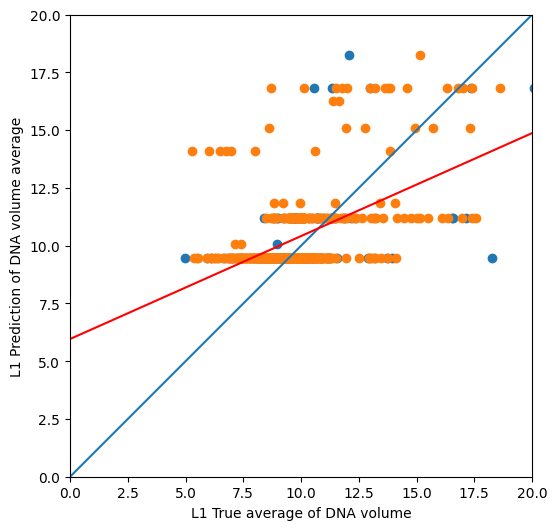

In [ ]:
def randomforest_regressor(x_train, x_test, y_train, y_test):
    regr = RandomForestRegressor(max_depth=2,n_estimators=10)
    regr.fit(x_train, y_train)

    test_predictions = regr.predict(x_test).flatten()
    train_predictions = regr.predict(x_train).flatten()
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    with open('../saved_model/randomforest_model_l1.pkl', 'wb') as f:
        pickle.dump(regr, f)
randomforest_regressor(x_train, x_test, y_train, y_test)

In [ ]:
def voting_regressor(x_train, x_test, y_train, y_test):
    r1 = LinearRegression()
    r2 = RandomForestRegressor(n_estimators=10)
    r3 = KNeighborsRegressor()
    X = x_train
    y = y_train
    er = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])
    er = er.fit(X, y)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    plt.figure(figsize=(6,6))
    plt.scatter(y_test, test_predictions)
    plt.scatter(y_train, train_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,20])
    plt.ylim([0,20])
    _ = plt.plot([0,20], [0,20])

    plt.plot([0,20], res.intercept + res.slope*np.array([0, 20]), 'r', label='fitted line')

        # Save the model
    #with open('../saved_model/randomforest_model_l1.pkl', 'wb') as f:
    #    pickle.dump(regr, f)
voting_regressor(x_train, x_test, y_train, y_test)

AttributeError: 'NoneType' object has no attribute 'split'

In [24]:
!pip install --upgrade pip

In [13]:
!pip3 install scikit-learn==1.4.1.post

ERROR: Could not find a version that satisfies the requirement scikit-learn==1.4.1.post (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2, 1.4.0rc1, 1.4.0, 1.4.1.post1, 1.4.2)
ERROR: No matching distribution found for scikit-learn==1.4.1.post


In [102]:
## これ！！

def bagging_regressor(x_train,x_test,y_train,y_test):
    X = x_train
    y = y_train
    er = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=10),n_estimators=10)
    er = er.fit(X, y)

        # Save the model
    with open('../saved_model/bagging_model_L1_initial.pkl', 'wb') as f:
        pickle.dump(er, f)
    

    test_predictions = er.predict(x_test)
    train_predictions = er.predict(x_train)
    res = linregress(y_test, test_predictions)

    max_lim = 45

    plt.figure(figsize=(6,6))
    plt.scatter(y_train, train_predictions)
    plt.scatter(y_test, test_predictions)
    # plt.xlabel('True Values [mc]')
    # plt.ylabel('Predictions [mc]')
    plt.xlabel('L1 True average of DNA volume')
    plt.ylabel('L1 Prediction of DNA volume average')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,max_lim])
    plt.ylim([0,max_lim])
    _ = plt.plot([0,max_lim], [0,max_lim])

    print(er.score(x_test, y_test))

    

    plt.plot([0,max_lim], res.intercept + res.slope*np.array([0, max_lim]), 'r', label='fitted line')

0.5576582157789448


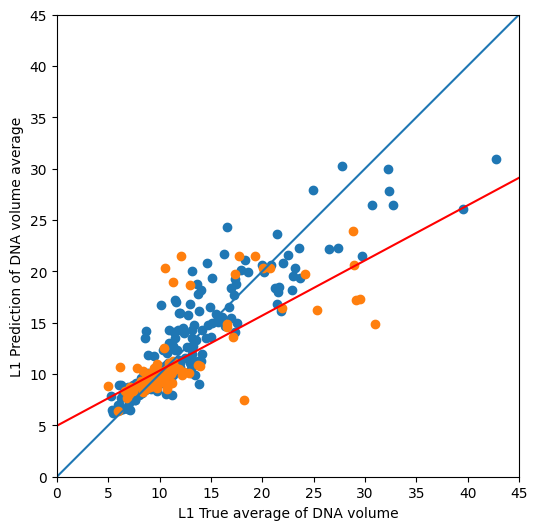

In [103]:
bagging_regressor(x_train, x_test, y_train, y_test)